In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import math

In [2]:
Ftrue = np.load("Ftrue.npy")

In [3]:
Ftrue

array([[ 6.67972386e-12, -7.85049965e-10,  1.17921973e-07],
       [-9.75936932e-10, -4.86806496e-12,  3.28699187e-05],
       [ 4.23506595e-07, -3.21704070e-05, -2.12002222e-04]])

In [4]:
qs = np.load("qs.npy",allow_pickle=True).item()
q1 = qs["q1"]
q2 = qs["q2"]

# Exercise 9.1

In [5]:
def Fest_8point(q1,q2):
    i = 0
    B = np.array([q1[0][i]*q2[0][i],q1[0][i]*q2[1][i],q1[0][i],q1[1][i]*q2[0][i],q1[1][i]*q2[1][i],q1[1][i],q2[0][i],q2[1][i],1])
    for i in range(1,len(q1[0])):
        Btemp = np.array([q1[0][i]*q2[0][i],q1[0][i]*q2[1][i],q1[0][i],q1[1][i]*q2[0][i],q1[1][i]*q2[1][i],q1[1][i],q2[0][i],q2[1][i],1])
        B = np.vstack((B,Btemp))
        
        _,_,vh = np.linalg.svd(B.T@B)
        F = np.reshape(vh[-1],(3,3)).T
    
    return F

In [6]:
F = Fest_8point(q1,q2)

In [7]:
F

array([[ 3.07968295e-08, -3.61878789e-06,  5.43556218e-04],
       [-4.49880267e-06, -2.24410733e-08,  1.51520188e-01],
       [ 1.95225258e-03, -1.48295655e-01, -9.77264511e-01]])

In [8]:
F1 = F/F[-1,-1]*Ftrue[-1,-1]

In [9]:
F1 = F1*-1

In [10]:
F1

array([[-6.68088958e-12,  7.85039327e-10, -1.17916004e-07],
       [ 9.75944745e-10,  4.86823922e-12, -3.28699305e-05],
       [-4.23510605e-07,  3.21704187e-05,  2.12002222e-04]])

In [11]:
Ftrue

array([[ 6.67972386e-12, -7.85049965e-10,  1.17921973e-07],
       [-9.75936932e-10, -4.86806496e-12,  3.28699187e-05],
       [ 4.23506595e-07, -3.21704070e-05, -2.12002222e-04]])

In [29]:
print('The Ftrue is :\n',Ftrue)
print('The Fest is :\n',F1)

The Ftrue is :
 [[ 6.67972386e-12 -7.85049965e-10  1.17921973e-07]
 [-9.75936932e-10 -4.86806496e-12  3.28699187e-05]
 [ 4.23506595e-07 -3.21704070e-05 -2.12002222e-04]]
The Fest is :
 [[-6.68088958e-12  7.85039327e-10 -1.17916004e-07]
 [ 9.75944745e-10  4.86823922e-12 -3.28699305e-05]
 [-4.23510605e-07  3.21704187e-05  2.12002222e-04]]


In [12]:
(F*Ftrue).sum() / (np.linalg.norm(F)*np.linalg.norm(Ftrue))

0.9999999999999963

In [13]:
(F1*Ftrue).sum() / (np.linalg.norm(F1)*np.linalg.norm(Ftrue))

-0.9999999999999967

# Exercise 9.2

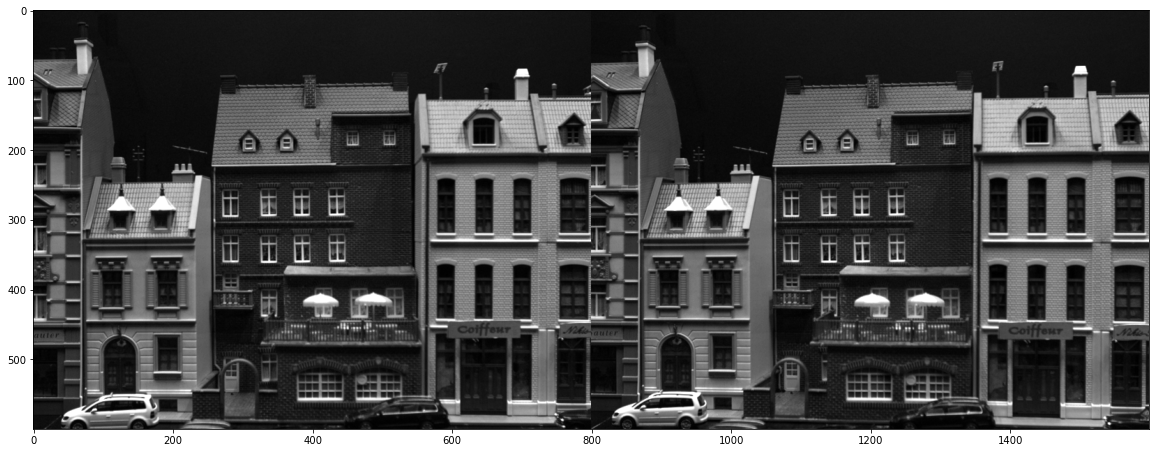

In [14]:
data = np.load('TwoImageData.npy',allow_pickle=True).item()
im1 = data['im1']
im2 = data['im2']

hmerge = np.hstack((im1, im2))
plt.figure(figsize=(20,20))
plt.imshow(hmerge,"gray")

In [15]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(im1, None)##key points and description
kp2, des2 = sift.detectAndCompute(im2, None)
bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(des1, des2)
outimg = cv2.drawMatches(im1, kp1, im2, kp2, matches[:20],None,flags = 2)


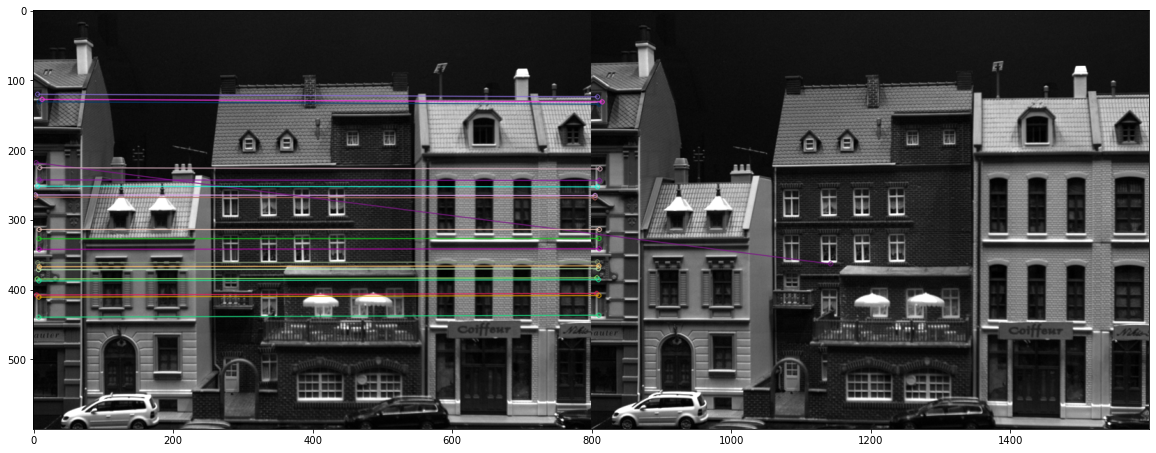

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(outimg)

# Exercise 9.3

In [17]:
#get match points coordinates
match1c = []
match2c = []
for match in matches:
    match1 = kp1[match.queryIdx].pt
    match2 = kp2[match.trainIdx].pt
    
    match1c.append(match1)
    match2c.append(match2)

match1c = np.asarray(match1c).T
match2c = np.asarray(match2c).T

In [18]:
#Homogeneous coordinates
match1ch = np.vstack((match1c,np.ones(len(match1c[0]))))
match2ch = np.vstack((match2c,np.ones(len(match1c[0]))))

In [19]:
def SampsonsDistance(F, p1,p2):
    a = (p2.T@F@p1)**2
    b = (p2.T@F)[0]**2
    c = (p2.T@F)[1]**2
    d = (F@p1)[0]**2
    e = (F@p1)[1]**2
    
    dsamp = a/(b+c+d+e)
    
    return dsamp

In [36]:
def consensus(F,p1,p2):
    #p = np.vstack((p,np.ones(len(p[0]))))
    number = 0
    inliers_index = []
    for i in range(len(p1[0])):
        p1i =p1[:,i] 
        p2i = p2[:,i]
        dsamp = SampsonsDistance(F,p1i,p2i)
        if dsamp<3.84*(3**2):
            number = number+1
            inliers_index.append(i)
    return number,np.asarray(inliers_index)

In [39]:
def RANSAC_F(match1ch,match2ch,iterations):
    maxnumber = 0   
    for i in range(iterations):
        index = np.random.choice(len(match1ch[0]),8,replace=False)
        p1 = match1ch[:,index]
        p2 = match2ch[:,index]
        Fest = Fest_8point(p1,p2)       
        number,_ = consensus(Fest,match1ch,match2ch)
        if number>maxnumber:
            maxnumber = number
            Fbest = Fest
            print("the %d is the best estimation, the max number is %d"%(i,maxnumber))
    
    
    _,inliers_index = consensus(Fbest,match1ch,match2ch)
    Fbsmatch = Fest_8point(match1ch[:,inliers_index],match2ch[:,inliers_index])
    return Fbsmatch,inliers_index

In [22]:
Fest,inliers_index = RANSAC_F(match1ch, match2ch,1000)

the 0 is the best estimation, the max number is 1341
the 2 is the best estimation, the max number is 1450
the 3 is the best estimation, the max number is 1507
the 5 is the best estimation, the max number is 1794
the 7 is the best estimation, the max number is 1904
the 9 is the best estimation, the max number is 1927
the 98 is the best estimation, the max number is 1928
the 406 is the best estimation, the max number is 1929


In [27]:
(F123*Ftrue).sum() / (np.linalg.norm(F123)*np.linalg.norm(Ftrue)) 

0.9931538039597596

In [23]:
(Fest*Ftrue).sum() / (np.linalg.norm(Fest)*np.linalg.norm(Ftrue))

-0.9968281654428196

In [24]:
_,inliers_index = consensus(Fest,match1ch,match2ch)
F123 = Fest_8point(match1ch[:,inliers_index],match2ch[:,inliers_index])

In [26]:
F123 = F123/F123[-1,-1]*Ftrue[-1,-1]

# Exercise 9.4

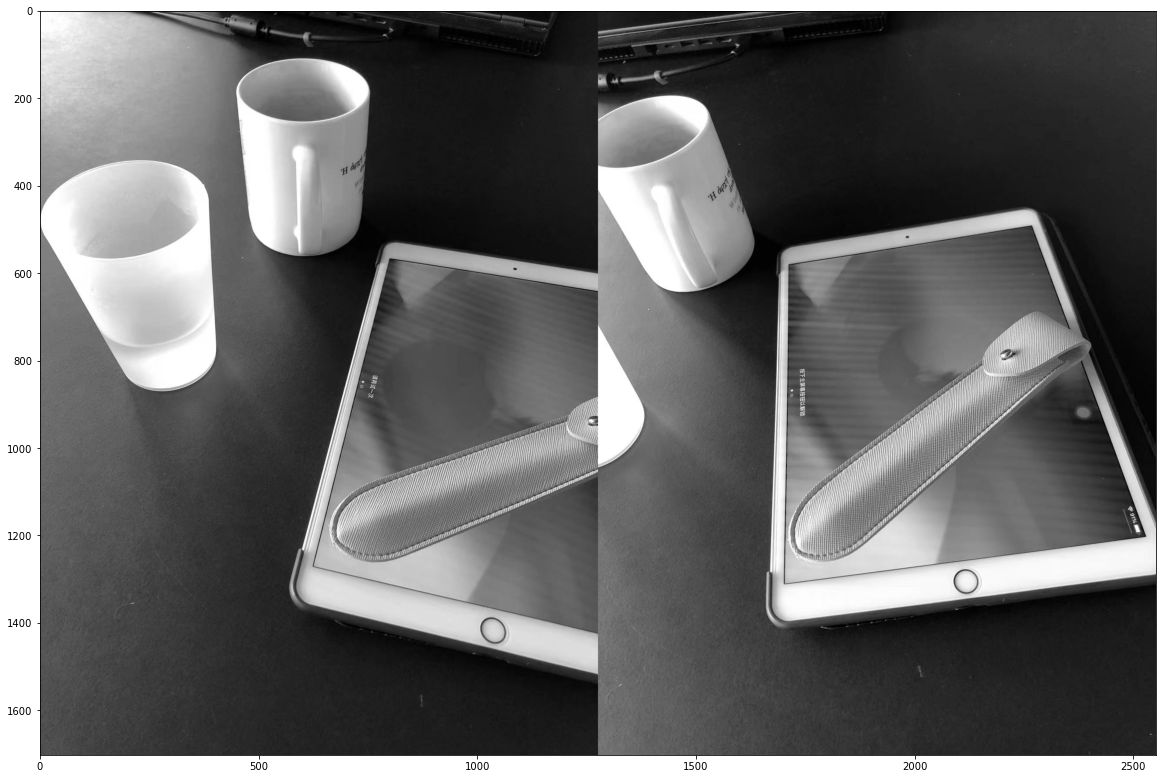

In [31]:
im1 = cv2.imread('test1.jpg')
img1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im2 = cv2.imread('test2.jpg')
img2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
hmerge = np.hstack((img1, img2))
plt.figure(figsize=(20,20))
plt.imshow(hmerge,"gray")

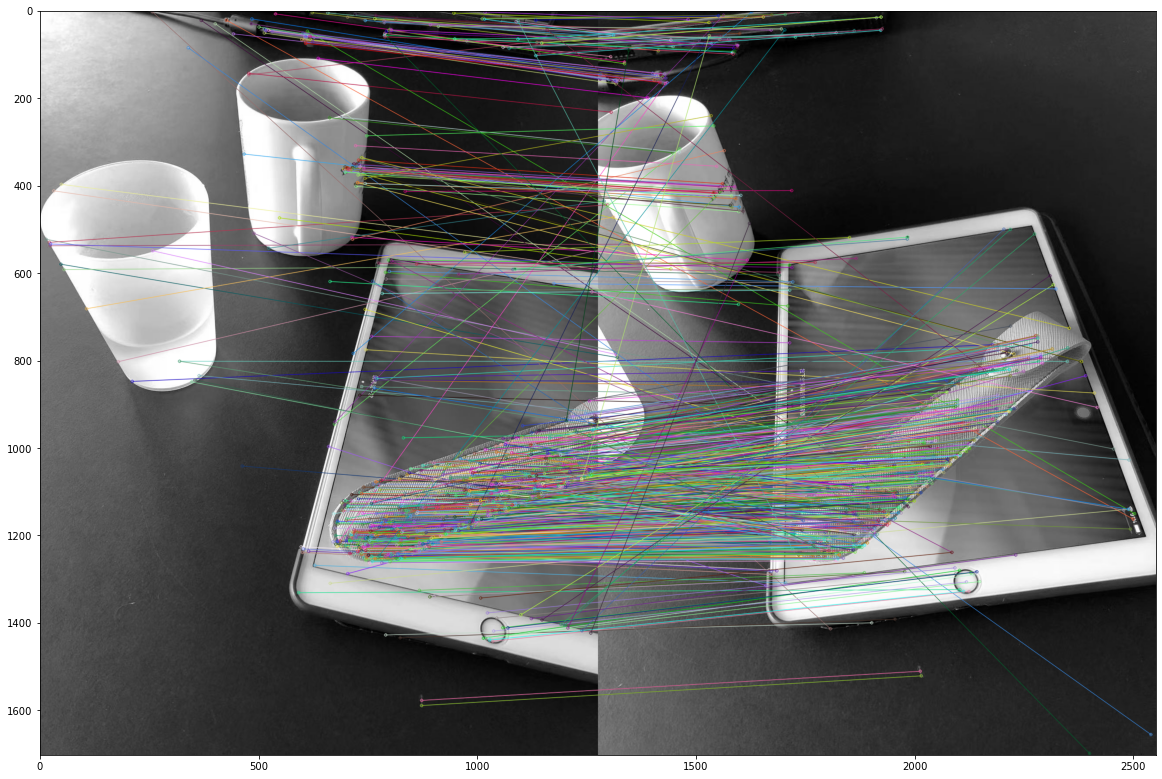

In [32]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)##key points and description
kp2, des2 = sift.detectAndCompute(img2, None)
bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(des1, des2)
outimg = cv2.drawMatches(img1, kp1, img2, kp2, matches,None,flags = 2)
plt.figure(figsize=(20,20))
plt.imshow(outimg)

In [33]:
#get match points coordinates
match1c = []
match2c = []
for match in matches:
    match1 = kp1[match.queryIdx].pt
    match2 = kp2[match.trainIdx].pt
    
    match1c.append(match1)
    match2c.append(match2)

match1c = np.asarray(match1c).T
match2c = np.asarray(match2c).T

#Homogeneous coordinates
match1ch = np.vstack((match1c,np.ones(len(match1c[0]))))
match2ch = np.vstack((match2c,np.ones(len(match1c[0]))))

In [41]:
Fest,inliers_index = RANSAC_F(match1ch, match2ch,1000)

the 0 is the best estimation, the max number is 267
the 1 is the best estimation, the max number is 429
the 28 is the best estimation, the max number is 455
the 235 is the best estimation, the max number is 489
the 782 is the best estimation, the max number is 496


In [43]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

inMatches = np.array([matches])[0, inliers_index][:]
inMatches = totuple(inMatches)

print(len(matches), len(inMatches))

728 496


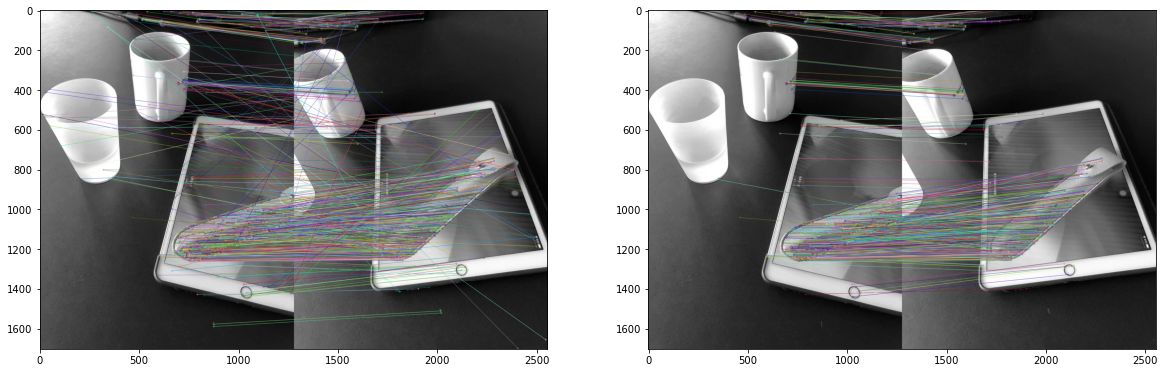

In [45]:
outimg1 = cv2.drawMatches(img1, kp1, img2, kp2, matches,None,flags = 2)
outimg2 = cv2.drawMatches(img1, kp1, img2, kp2, inMatches,None,flags = 2)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(outimg1,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(outimg2,cmap = 'gray')
plt.savefig('ex9_4.png')